# Load Libraries and Data

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, RFECV
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, recall_score, fbeta_score, precision_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from joblib import dump, load

In [ ]:
## Create a random instance to be passed to all random_state parameters
rs = np.random.RandomState(0)

In [ ]:
data = pd.read_csv("fetal_health.csv")

# Exploratory Data Analysis

In [ ]:
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [ ]:
# check if there are any duplicates
data.duplicated().sum() ## there are 13 duplicates

13

In [ ]:
# remove duplicates
data.drop_duplicates(inplace=True)   # removes 13 duplicates

## Correlation Matrix

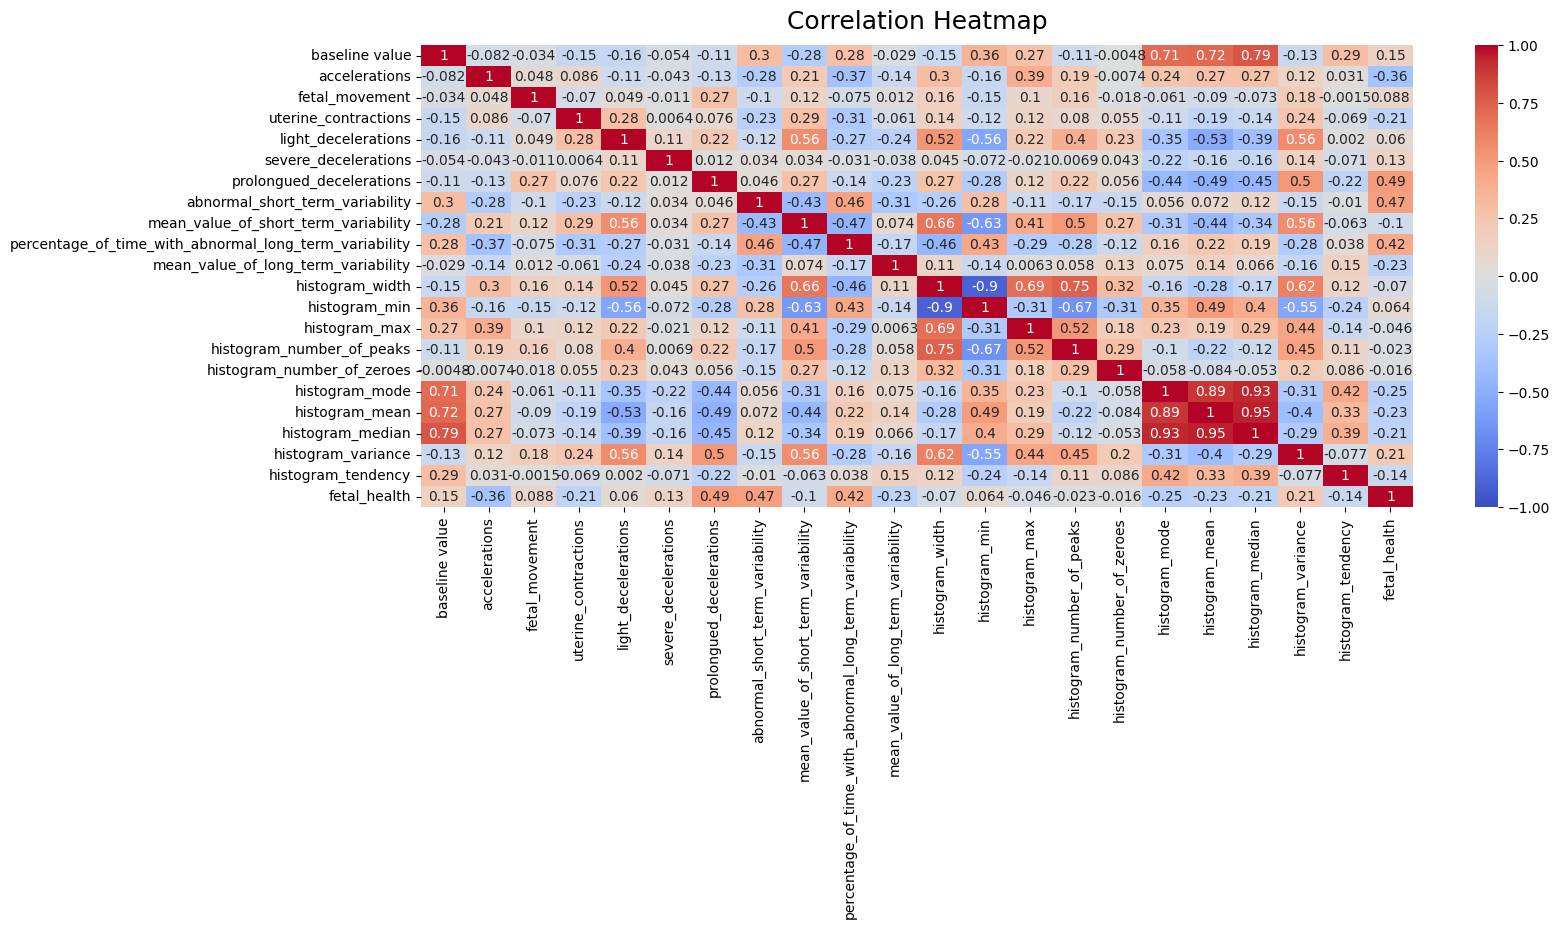

In [ ]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

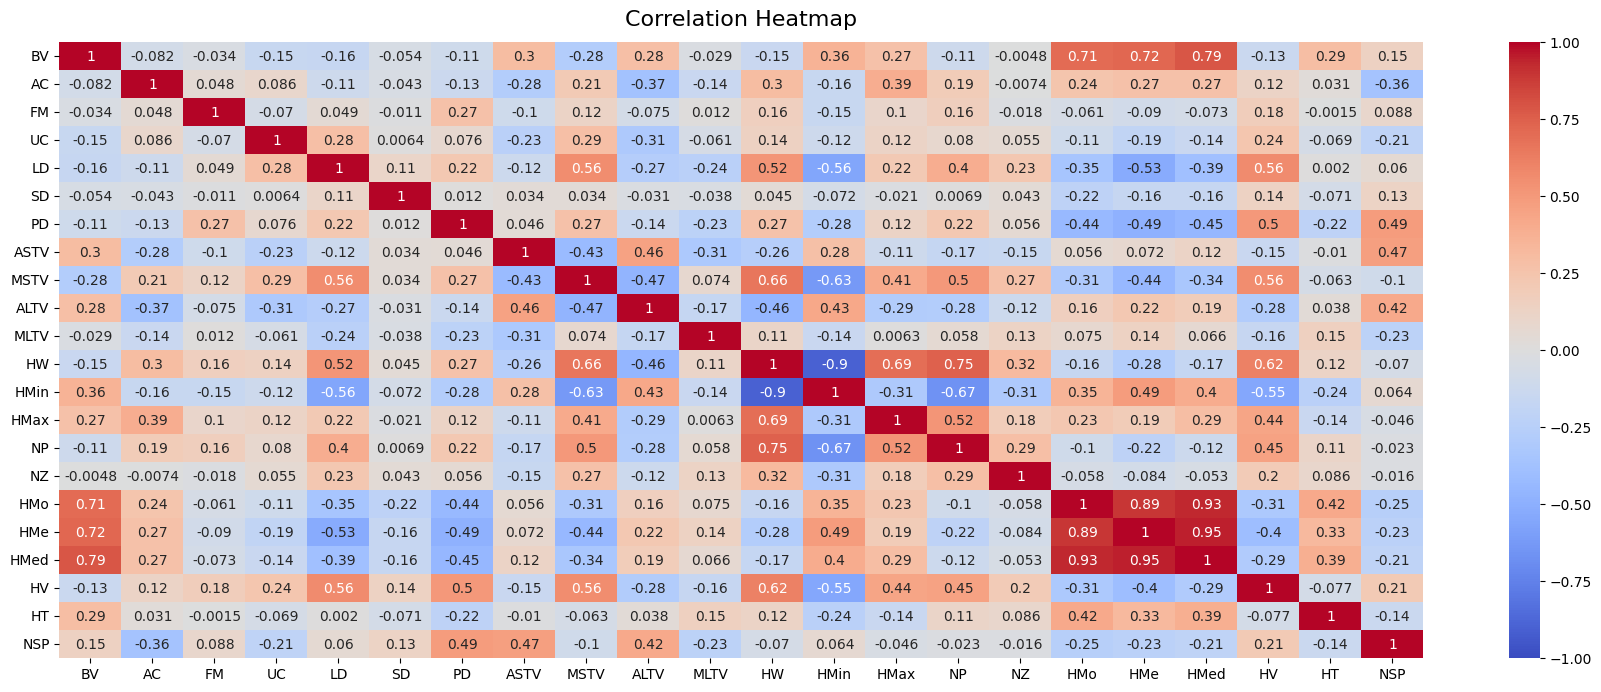

In [ ]:
# correlation matrix for report
data2 = data.copy(deep=True)
data2 = data2.rename(columns = {'baseline value': 'BV', 'accelerations': 'AC',
                        'fetal_movement': 'FM', 'uterine_contractions': 'UC',
                        'light_decelerations': 'LD', 'severe_decelerations': 'SD',
                        'prolongued_decelerations': 'PD', 'abnormal_short_term_variability': 'ASTV',
                        'mean_value_of_short_term_variability': 'MSTV',
                        'percentage_of_time_with_abnormal_long_term_variability': 'ALTV',
                        'mean_value_of_long_term_variability': 'MLTV',
                        'histogram_width': 'HW', 'histogram_min': 'HMin',
                        'histogram_max': 'HMax', 'histogram_number_of_peaks': 'NP',
                        'histogram_number_of_zeroes': 'NZ', 'histogram_mode': 'HMo',
                        'histogram_mean': 'HMe', 'histogram_median': 'HMed',
                        'histogram_variance': 'HV', 'histogram_tendency': 'HT',
                        'fetal_health': 'NSP'})

plt.figure(figsize=(22, 8))
heatmap = sns.heatmap(data2.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':16}, pad=12);

## Distribution of Features

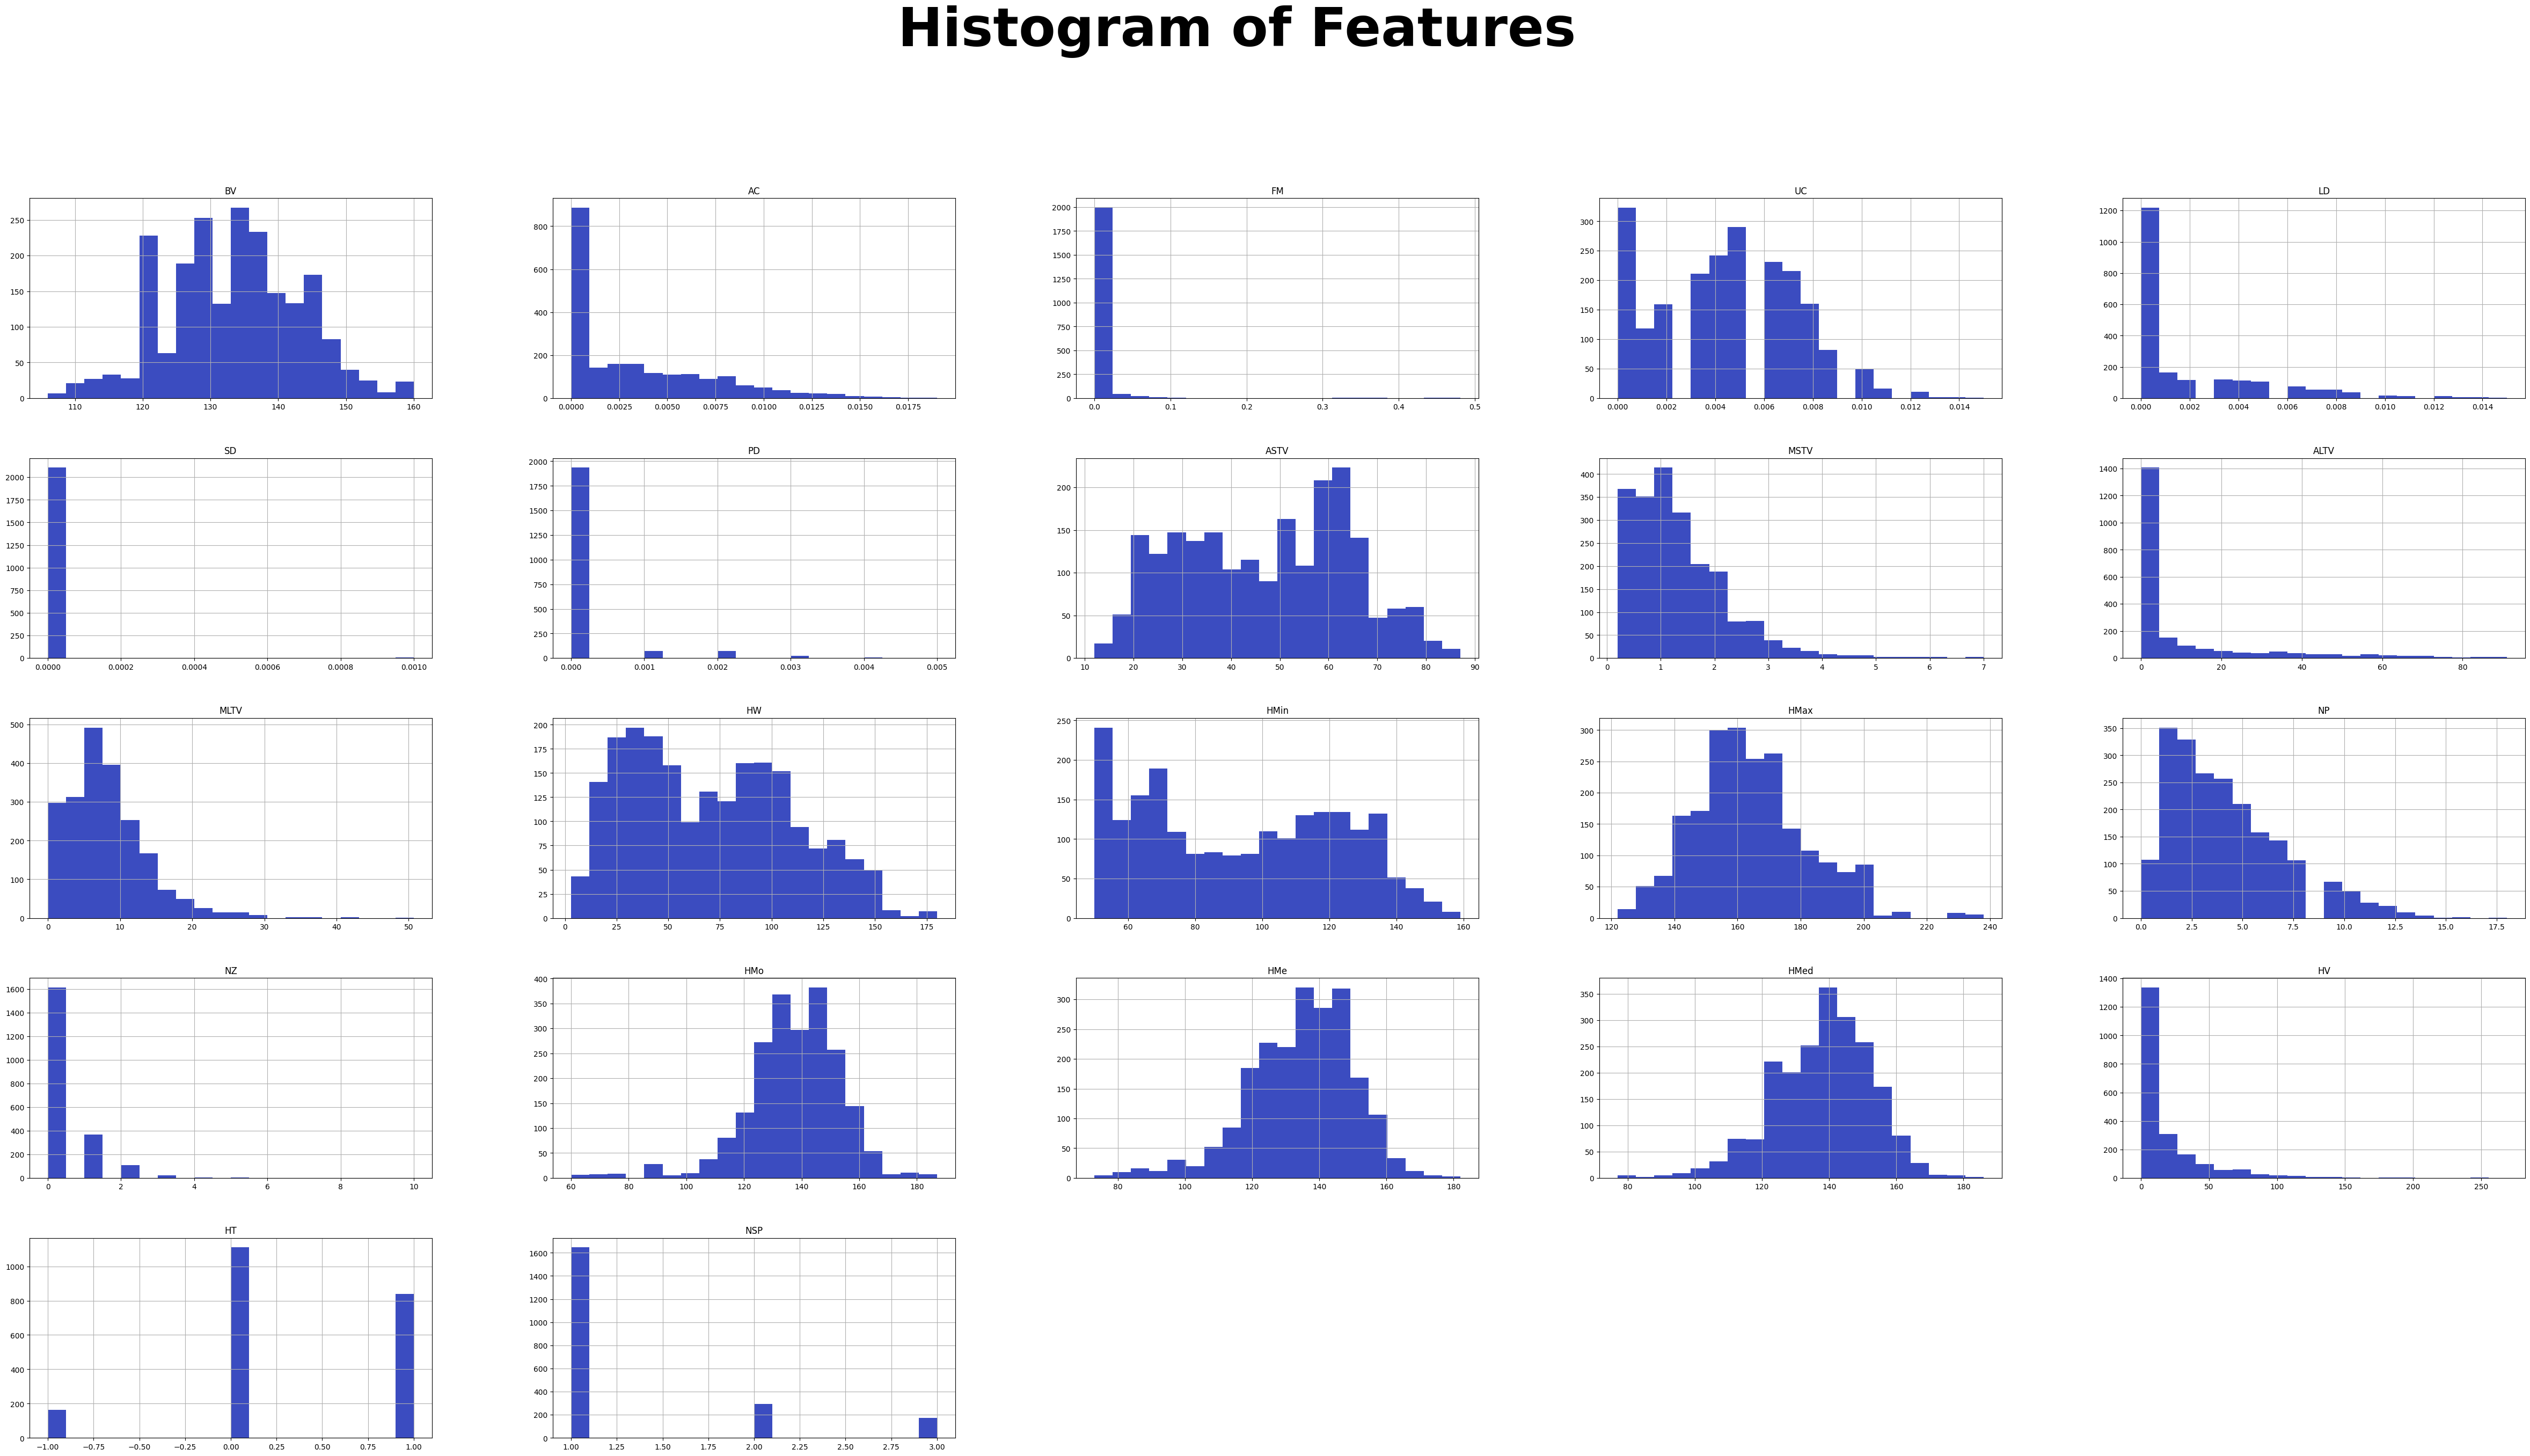

In [ ]:
data2.hist(bins=20, figsize=(60, 30), color=plt.get_cmap('coolwarm')(np.linspace(0, 1, 1)), grid=True)
hist_features = plt.suptitle('Histogram of Features',
                             y=1,
                             fontsize=72,
                             fontweight='bold')

## Class Imbalance

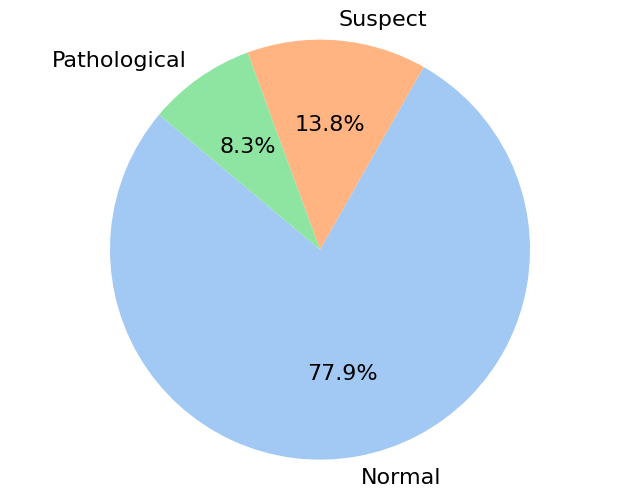

In [ ]:
# Define category labels
category_labels = {1.0: 'Normal', 2.0: 'Suspect', 3.0: 'Pathological'}

# Define your color palette using seaborn
palette = sns.color_palette("pastel")

# Plot pie chart
plt.figure(figsize=(8, 6))
data['fetal_health'].value_counts().rename(index=category_labels).plot(kind='pie', autopct='%1.1f%%', startangle=140, fontsize = 16, colors = palette)
plt.ylabel('')  # Remove the y-axis label
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Feature Selection

Text(0.5, 1.0, 'Correlation of Numerical Features with fetal_health')

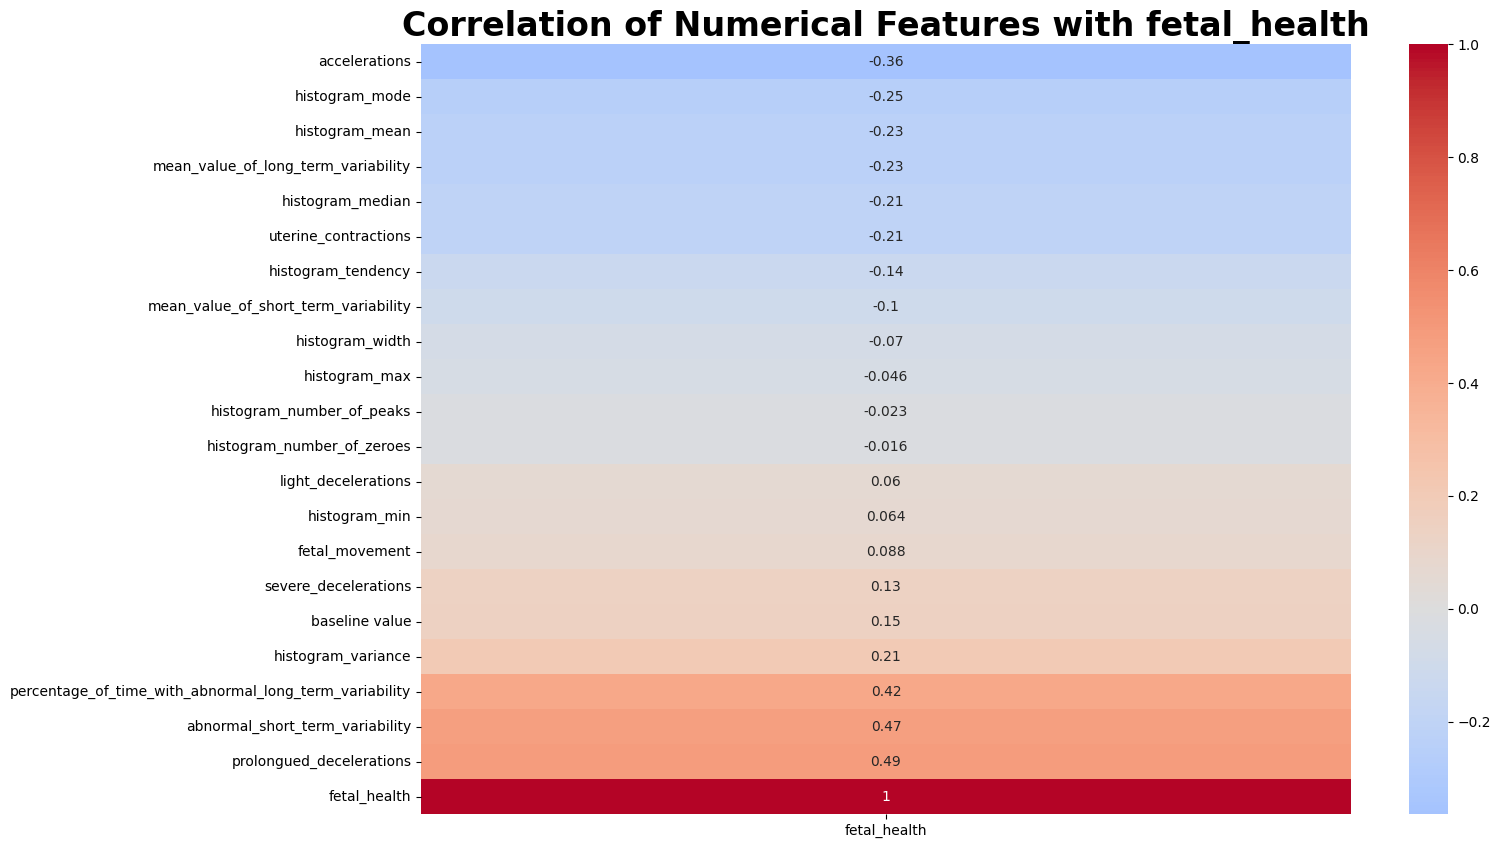

In [ ]:
# strongly correlated with fetal health:
correlation_matrix = data.corr()['fetal_health']

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix.sort_values().to_frame(), annot=True, cmap='coolwarm', center=0)

plt.title("Correlation of Numerical Features with fetal_health",
                    fontsize=24,
                    fontweight="bold")

Features strongly correlated (|r| >= 0.4):
- prolongued decelerations
- percentage of time with abnormal short term variability
- percentage of time with abnormal long term variability

In [ ]:
data3 = data.drop(['histogram_variance'], axis = 1)
X_data = data3.drop(['fetal_health'], axis = 1)
y_data = data3['fetal_health']
feature_names = data3.columns.delete(20).values

In [ ]:
# recode the data into a binary problem:
y_normal = y_data.copy()
y_suspect = y_data.copy()
y_pathological = y_data.copy()

for i in range(len(y_data)):
  if (y_data.iloc[i] == 1):  # normal case
    y_suspect.iloc[i] = 0
    y_pathological.iloc[i] = 0
  elif (y_data.iloc[i] == 2):  # suspect case
    y_normal.iloc[i] = 0
    y_suspect.iloc[i] = 1
    y_pathological.iloc[i] = 0
  elif (y_data.iloc[i] == 3):  # pathological case
    y_normal.iloc[i] = 0
    y_suspect.iloc[i] = 0
    y_pathological.iloc[i] = 1

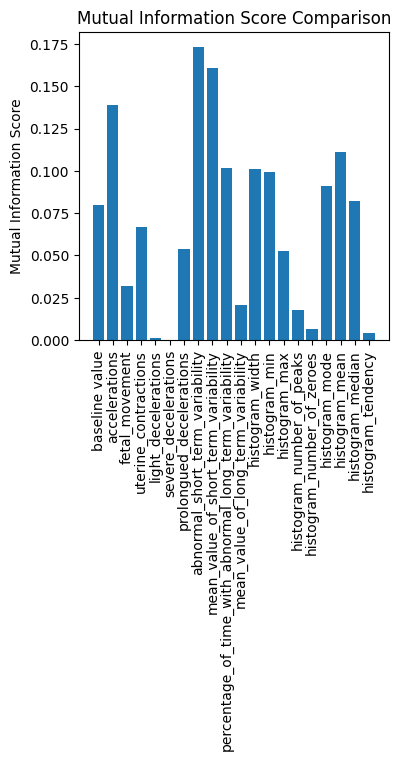

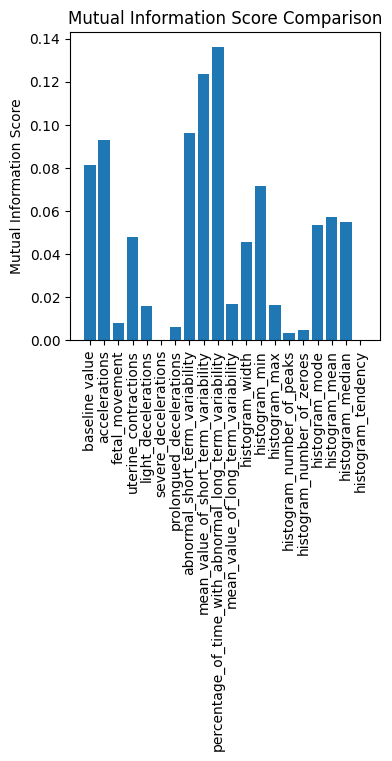

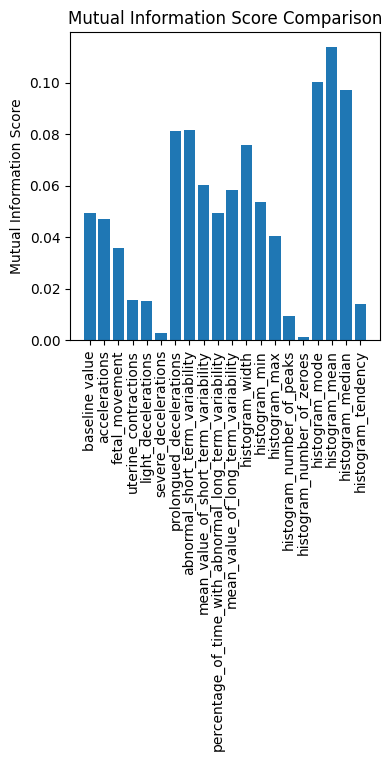

In [ ]:
# MI for normal case:
MI_score_normal = mutual_info_classif(X_data, y_normal, random_state=0)
plt.figure(figsize=(4,4))
plt.bar(x=feature_names, height=MI_score_normal)
plt.xticks(rotation='vertical')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Comparison')
plt.show()

# MI for suspect case:
MI_score_suspect = mutual_info_classif(X_data, y_suspect, random_state=0)
plt.figure(figsize=(4,4))
plt.bar(x=feature_names, height=MI_score_suspect)
plt.xticks(rotation='vertical')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Comparison')
plt.show()

# MI for pathological case:
MI_score_pathological = mutual_info_classif(X_data, y_pathological, random_state=0)
plt.figure(figsize=(4,4))
plt.bar(x=feature_names, height=MI_score_pathological)
plt.xticks(rotation='vertical')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Comparison')
plt.show()

In [ ]:
# remove features with low MI score
data4 = data3.drop(['severe_decelerations', 'light_decelerations',
                    'histogram_number_of_zeroes', 'histogram_number_of_peaks',
                    'histogram_tendency', 'uterine_contractions'], axis = 1)

Features to retain:
- prolongued decelerations
- percentage of time with abnormal short term variability
- percentage of time with abnormal long term variability
- histogram mean
- mean value short term variability
- accelerations

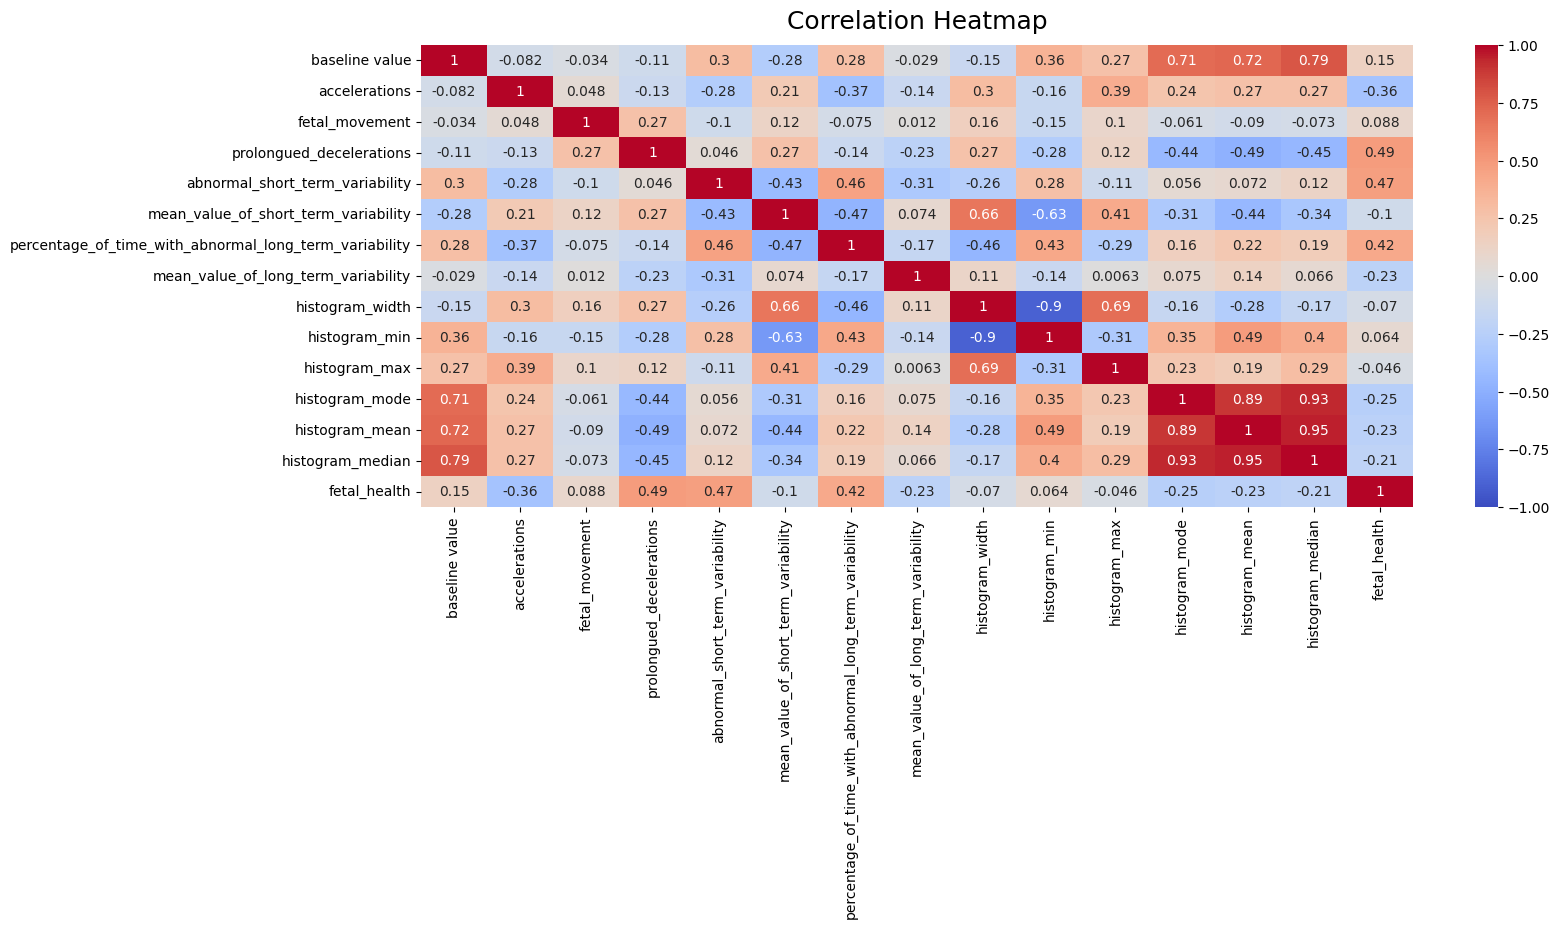

In [ ]:
# consider correlations among remaining features
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(data4.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

In [ ]:
# remove features that are strongly correlated with those that are being retained
data5 = data4.drop(['histogram_mode', 'histogram_median', 'histogram_width', 'histogram_min',
                    'baseline value'], axis = 1)

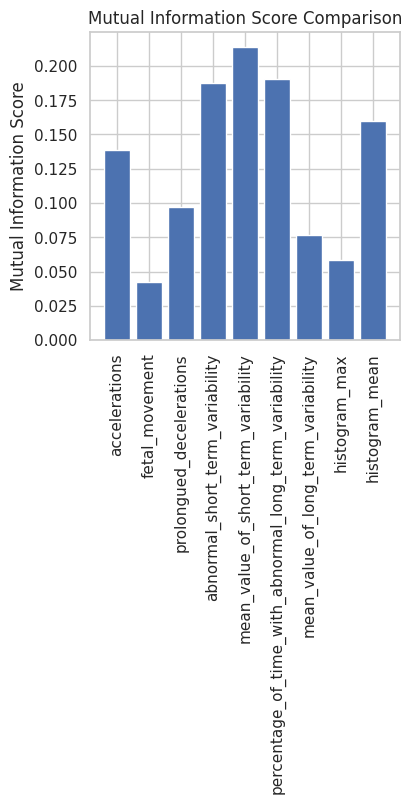

In [55]:
# consider overall MI score:
# consider overall MI score, if any are very low and not very important for pathological remove:
X_data5 = data5.drop(['fetal_health'], axis = 1)
y_data5 = data5['fetal_health']
feature_names = data5.columns.delete(9).values

MI_score = mutual_info_classif(X_data5, y_data5, random_state=0)

plt.figure(figsize=(4,4))
plt.bar(x=feature_names, height=MI_score)
plt.xticks(rotation='vertical')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Comparison')

plt.show()

In [ ]:
# fetal movement & histogram max can be removed, not too important to the target variable overall
data_sel = data5.drop(['fetal_movement', 'histogram_max'], axis = 1)
data_sel.info()   # 7 features

<class 'pandas.core.frame.DataFrame'>
Index: 2113 entries, 0 to 2125
Data columns (total 8 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   accelerations                                           2113 non-null   float64
 1   prolongued_decelerations                                2113 non-null   float64
 2   abnormal_short_term_variability                         2113 non-null   float64
 3   mean_value_of_short_term_variability                    2113 non-null   float64
 4   percentage_of_time_with_abnormal_long_term_variability  2113 non-null   float64
 5   mean_value_of_long_term_variability                     2113 non-null   float64
 6   histogram_mean                                          2113 non-null   float64
 7   fetal_health                                            2113 non-null   float64
dtypes: float64(8)
memory usage: 148.6 KB


# Machine Learning Pipelines

## All Features

In [ ]:
X = data.drop(['fetal_health'], axis = 1)
y = data['fetal_health']

# FIRST SPLIT INTO TRAIN/TEST SETS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)

### Decision Tree + SMOTE

In [ ]:
# Create a pipeline with the following steps:
    # 1. Standardise data
    # 2. Oversampling
    # 3. Hyperparameter tuning (Grid Search CV)
    # 4. Retrain Model
    # 4. Evaluate model

# Use this pipeline with cross validation (k=10)

## Define steps of pipeline
sc = StandardScaler()
smote = SMOTE(random_state = rs)
estimator = DecisionTreeClassifier(random_state=rs)

## Create pipeline
pipeline = ImbPipeline([('sc', sc),
                        ('resampling', smote),
                        ('estimator', estimator)])

## Specify cross validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 100, random_state=rs)

## Define what scores you want to calculate
scoring = {"Balanced_Accuracy": "balanced_accuracy",
           "Precision": "precision_weighted",
           "Recall": "recall_weighted"}

## Define hyperparameter grid
hyperparameter_grid = {'estimator__criterion': ['gini', 'entropy'],
                       'estimator__max_depth': [5, 10, 15, 20],
                       'estimator__min_samples_split': [2, 5, 10],
                       'estimator__min_samples_leaf': [1, 2, 4]}

## Define grid search CV process
grid_search = GridSearchCV(pipeline,
                           param_grid = hyperparameter_grid,
                           scoring = scoring,
                           refit = "Recall",
                           n_jobs = 2,
                           cv = cv)

In [ ]:
## Carry out grid search CV and get results
grid_search.fit(X_train, y_train)

## Print the best hyperparameters
print('Best hyperparameters are: '+str(grid_search.best_params_))

## Save the trained classifier
dump(grid_search, 'dt_classifier_os.joblib')

### Decision Tree + RUS

In [ ]:
## Define steps of pipeline
sc = StandardScaler()
rus = RandomUnderSampler(random_state = rs, replacement = False)
estimator = DecisionTreeClassifier(random_state=rs)

## Create pipeline
pipeline = ImbPipeline([('sc', sc),
                        ('resampling', rus),
                        ('estimator', estimator)])

## Specify cross validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 100, random_state=rs)

## Define what scores you want to calculate
scoring = {"Balanced_Accuracy": "balanced_accuracy",
           "Precision": "precision_weighted",
           "Recall": "recall_weighted"}

## Define hyperparameter grid
hyperparameter_grid = {'estimator__criterion': ['gini', 'entropy'],
                       'estimator__max_depth': [5, 10, 15, 20],
                       'estimator__min_samples_split': [2, 5, 10],
                       'estimator__min_samples_leaf': [1, 2, 4]}

## Define grid search CV process
grid_search = GridSearchCV(pipeline,
                           param_grid = hyperparameter_grid,
                           scoring = scoring,
                           refit = "Recall",
                           n_jobs = 2,
                           cv = cv)

In [ ]:
## Carry out grid search CV and get results
grid_search.fit(X_train, y_train)

## Print the best hyperparameters
print('Best hyperparameters are: '+str(grid_search.best_params_))

## Save the trained classifier
dump(grid_search, 'dt_classifier_rus.joblib')

### XGBoost + SMOTE

In [ ]:
## Define steps of pipeline
sc = StandardScaler()  # always the same, to be used on the train set
smote = SMOTE(random_state = rs)
estimator = XGBClassifier(random_state = rs)

# create pipeline
pipeline = ImbPipeline([('sc', sc),
                        ('resampling', smote),
                        ('estimator', estimator)])

## Specify cross validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 100, random_state=rs)

## Define what scores you want to calculate
scoring = {"Balanced_Accuracy": "balanced_accuracy",
           "Precision": "precision_weighted",
           "Recall": "recall_weighted"}

## Define hyperparameter grid
hyperparameter_grid = {
    "xgbclassifier__learning_rate":[0.01, 0.3, 0.5],
    "xgbclassifier__n_estimators": [10, 100, 200],
    "xgbclassifier__max_depth": [1, 3, 5],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__use_label_encoder": [False],
    "xgbclassifier__booster": ["gbtree"],
    "xgbclassifier__eval_metric": ["logloss"]}

## Define grid search CV process
grid_search = GridSearchCV(pipeline,
                           param_grid = hyperparameter_grid,
                           scoring = scoring,
                           refit = "Recall",
                           n_jobs = 2,
                           cv = cv)

In [ ]:
## Carry out grid search CV (on train set) and get results
grid_search.fit(X_train, (y_train-1))

## Print the best hyperparameters
print('Best hyperparameters are: '+str(grid_search.best_params_))

## Save the trained classifier
dump(grid_search, 'xgboost_classifier.joblib')

### XGBoost + RUS

In [ ]:
## Define steps of pipeline
sc = StandardScaler()
rus = RandomUnderSampler(random_state = rs, replacement = False)
estimator = XGBClassifier(random_state = rs)

## Create pipeline
pipeline = ImbPipeline([('sc', sc),
                        ('resampling', rus),
                        ('estimator', estimator)])

## Specify cross validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 100, random_state=rs)

## Define what scores you want to calculate
scoring = {"Balanced_Accuracy": "balanced_accuracy",
           "Precision": "precision_weighted",
           "Recall": "recall_weighted"}

## Define hyperparameter grid
hyperparameter_grid = {
    "xgbclassifier__learning_rate":[0.01, 0.3, 0.5],
    "xgbclassifier__n_estimators": [10, 100, 200],
    "xgbclassifier__max_depth": [1, 3, 5],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__use_label_encoder": [False],
    "xgbclassifier__booster": ["gbtree"],
    "xgbclassifier__eval_metric": ["logloss"]}

## Define grid search CV process
grid_search = GridSearchCV(pipeline,
                           param_grid = hyperparameter_grid,
                           scoring = scoring,
                           refit = "Recall",
                           n_jobs = 2,
                           cv = cv)

In [ ]:
## Carry out grid search CV (on train set) and get results
grid_search.fit(X_train, (y_train-1))

## Print the best hyperparameters
print('Best hyperparameters are: '+str(grid_search.best_params_))

## Save the trained classifier
dump(grid_search, 'xgboost_rus.joblib')

## Feature Selection

In [ ]:
## Filter data for only selected features
fs_data = data_sel

## Specify X (features) and y (target)
X_fs = fs_data.drop(['fetal_health'], axis = 1)
y_fs = fs_data['fetal_health']

# FIRST SPLIT INTO TRAIN/TEST SETS
X_fs_train, X_fs_test, y_fs_train, y_fs_test = train_test_split(X_fs, y_fs, test_size=0.2, stratify=y, random_state=rs)

### Decision Tree + SMOTE

In [ ]:
## Define steps of pipeline
sc = StandardScaler()
smote = SMOTE(random_state = rs)
estimator = DecisionTreeClassifier(random_state=rs)

## Create pipeline
pipeline = ImbPipeline([('sc', sc),
                        ('resampling', smote),
                        ('estimator', estimator)])

## Specify cross validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 100, random_state=rs)

## Define what scores you want to calculate
scoring = {"Balanced_Accuracy": "balanced_accuracy",
           "Precision": "precision_weighted",
           "Recall": "recall_weighted"}

## Define hyperparameter grid
hyperparameter_grid = {'estimator__criterion': ['gini', 'entropy'],
                       'estimator__max_depth': [5, 10, 15, 20],
                       'estimator__min_samples_split': [2, 5, 10],
                       'estimator__min_samples_leaf': [1, 2, 4]}

## Define grid search CV process
grid_search = GridSearchCV(pipeline,
                           param_grid = hyperparameter_grid,
                           scoring = scoring,
                           refit = "Recall",
                           n_jobs = 2,
                           cv = cv)

In [ ]:
## Carry out grid search CV and get results
grid_search.fit(X_fs_train, y_fs_train) ## MUCH FASTER TO TRAIN

## Print the best hyperparameters
print('Best hyperparameters are: '+str(grid_search.best_params_))

## Save the trained classifier
dump(grid_search, 'dt_classifier_os_fs.joblib')

### Decision Tree + RUS

In [ ]:
## Define steps of pipeline
sc = StandardScaler()
rus = RandomUnderSampler(random_state = rs, replacement = False)
## cc = ClusterCentroids(random_state=rs)
## NOT USING CLUSTER CENTROIDS SINCE WASN'T FINSIHED AFTER 2.5 HOURS

estimator = DecisionTreeClassifier(random_state=rs)

## Create pipeline
pipeline = ImbPipeline([('sc', sc),
                        ('resampling', rus),
                        ('estimator', estimator)])

## Specify cross validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 100, random_state=rs)

## Define what scores you want to calculate
scoring = {"Balanced_Accuracy": "balanced_accuracy",
           "Precision": "precision_weighted",
           "Recall": "recall_weighted"}

## Define hyperparameter grid
hyperparameter_grid = {'estimator__criterion': ['gini', 'entropy'],
                       'estimator__max_depth': [5, 10, 15, 20],
                       'estimator__min_samples_split': [2, 5, 10],
                       'estimator__min_samples_leaf': [1, 2, 4]}

## Define grid search CV process
grid_search = GridSearchCV(pipeline,
                           param_grid = hyperparameter_grid,
                           scoring = scoring,
                           refit = "Recall",
                           n_jobs = 2,
                           cv = cv)

In [ ]:
## Carry out grid search CV and get results
grid_search.fit(X_fs_train, y_fs_train)

## Print the best hyperparameters
print('Best hyperparameters are: '+str(grid_search.best_params_))

## Save the trained classifier
dump(grid_search, 'dt_classifier_rus_fs.joblib')

### XGBoost + SMOTE

In [ ]:
## Define steps of pipeline
sc = StandardScaler()
smote = SMOTE(random_state = rs)
estimator = XGBClassifier(random_state = rs)

## Create pipeline
pipeline = ImbPipeline([('sc', sc),
                        ('resampling', smote),
                        ('estimator', estimator)])

## Specify cross validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 100, random_state=rs)

## Define what scores you want to calculate
scoring = {"Balanced_Accuracy": "balanced_accuracy",
           "Precision": "precision_weighted",
           "Recall": "recall_weighted"}

## Define hyperparameter grid
hyperparameter_grid = {
    "xgbclassifier__learning_rate":[0.01, 0.3, 0.5],
    "xgbclassifier__n_estimators": [10, 100, 200],
    "xgbclassifier__max_depth": [1, 3, 5],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__use_label_encoder": [False],
    "xgbclassifier__booster": ["gbtree"],
    "xgbclassifier__eval_metric": ["logloss"]}

## Define grid search CV process
grid_search = GridSearchCV(pipeline,
                           param_grid = hyperparameter_grid,
                           scoring = scoring,
                           refit = "Recall",
                           n_jobs = 2,
                           cv = cv)

In [ ]:
## Carry out grid search CV (on train set) and get results
grid_search.fit(X_fs_train, (y_fs_train-1))

## Print the best hyperparameters
print('Best hyperparameters are: '+str(grid_search.best_params_))

## Save the trained classifier
dump(grid_search, 'xgboost_classifier_feat_sel.joblib')

### XGBoost + RUS

In [ ]:
## Define steps of pipeline
sc = StandardScaler()
rus = RandomUnderSampler(random_state = rs, replacement = False)
estimator = XGBClassifier(random_state = rs)

## Create pipeline
pipeline = ImbPipeline([('sc', sc),
                        ('resampling', rus),
                        ('estimator', estimator)])

## Specify cross validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats = 100, random_state=rs)

## Define what scores you want to calculate
scoring = {"Balanced_Accuracy": "balanced_accuracy",
           "Precision": "precision_weighted",
           "Recall": "recall_weighted"}

## Define hyperparameter grid
hyperparameter_grid = {
    "xgbclassifier__learning_rate":[0.01, 0.3, 0.5],
    "xgbclassifier__n_estimators": [10, 100, 200],
    "xgbclassifier__max_depth": [1, 3, 5],
    "xgbclassifier__objective": ["binary:logistic"],
    "xgbclassifier__use_label_encoder": [False],
    "xgbclassifier__booster": ["gbtree"],
    "xgbclassifier__eval_metric": ["logloss"]}

## Define grid search CV process
grid_search = GridSearchCV(pipeline,
                           param_grid = hyperparameter_grid,
                           scoring = scoring,
                           refit = "Recall",
                           n_jobs = 2,
                           cv = cv)

In [ ]:
## Carry out grid search CV (on train set) and get results
grid_search.fit(X_fs_train, (y_fs_train-1))

## Print the best hyperparameters
print('Best hyperparameters are: '+str(grid_search.best_params_))

## Save the trained classifier
dump(grid_search, 'xgboost_rus_feat_sel.joblib')

# Evaluation

## Load Classifiers

In [ ]:
dt_smote = load('decision_tree_classifier.joblib')
dt_smote_fs = load('dt_classifier_os_fs.joblib')

dt_rus = load('dt_classifier_rus.joblib')
dt_rus_fs = load('dt_classifier_rus_fs.joblib')

xg_smote = load('xgboost_classifier.joblib')
xg_smote_fs = load('xgboost_classifier_feat_sel.joblib')

xg_rus = load('xgboost_rus.joblib')
xg_rus_fs = load('xgboost_rus_feat_sel.joblib')

## Balanced Accuracy (Test)

In [59]:
## Calculate balanced accuracy scores for each model, store in dictionary
balanced_accuracy_scores = {
    'Decision Tree (SMOTE)': balanced_accuracy_score(y_test, dt_smote.predict(X_test)),
    'Decision Tree (SMOTE with Feature Selection)': balanced_accuracy_score(y_fs_test, dt_smote_fs.predict(X_fs_test)),
    'Decision Tree (RUS)': balanced_accuracy_score(y_test, dt_rus.predict(X_test)),
    'Decision Tree (RUS with Feature Selection)': balanced_accuracy_score(y_fs_test, dt_rus_fs.predict(X_fs_test)),
    'XGBoost (SMOTE)': balanced_accuracy_score(y_test-1, xg_smote.predict(X_test)),
    'XGBoost (SMOTE with Feature Selection)': balanced_accuracy_score(y_fs_test-1, xg_smote_fs.predict(X_fs_test)),
    'XGBoost (RUS)': balanced_accuracy_score(y_test-1, xg_rus.predict(X_test)),
    'XGBoost (RUS with Feature Selection)': balanced_accuracy_score(y_fs_test-1, xg_rus_fs.predict(X_fs_test))
}


## Initialise empty list to store model information and scores
data = []

## Loop through dictionary, extract model information and balanced accuracy scores
for key, value in balanced_accuracy_scores.items():
    model_info = key.split(' (')
    model_type = model_info[0]
    feature_selection = 'Selected Features' if 'with Feature Selection' in key else 'All Features'
    resampling_info = model_info[1].split(' ')
    resampling = resampling_info[0] if 'with Feature Selection' in key else resampling_info[0][:-1]
    data.append([f"{model_type} ({resampling})", feature_selection, value])

## Create DataFrame
balanced_accuracy_df = pd.DataFrame(data, columns=['Model and Resampling', 'Feature Selection', 'Balanced Accuracy'])
balanced_accuracy_df

,Model and Resampling,Feature Selection,Balanced Accuracy
0,Decision Tree (SMOTE),All Features,0.864323
1,Decision Tree (SMOTE),Selected Features,0.949983
2,Decision Tree (RUS),All Features,0.900682
3,Decision Tree (RUS),Selected Features,0.911763
4,XGBoost (SMOTE),All Features,0.889645
5,XGBoost (SMOTE),Selected Features,0.977708
6,XGBoost (RUS),All Features,0.924317
7,XGBoost (RUS),Selected Features,0.951515


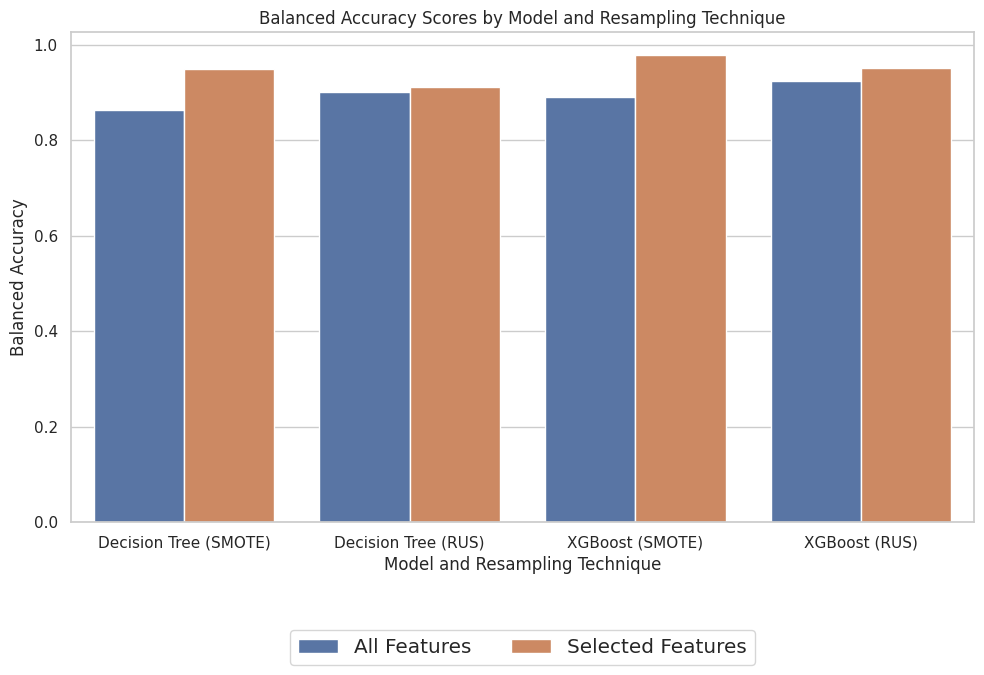

In [60]:
# Plot bar chart of balanced accuracies

plt.figure(figsize=(10, 6))
sns.barplot(x='Model and Resampling', y='Balanced Accuracy', hue='Feature Selection', data=balanced_accuracy_df)
plt.title('Balanced Accuracy Scores by Model and Resampling Technique')
plt.xlabel('Model and Resampling Technique')
plt.ylabel('Balanced Accuracy')
plt.xticks()
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2, fontsize= 'large')

plt.show()

## Balanced Accuracy (Train)

In [ ]:
## Calculate balanced accuracy scores for each model, store in dictionary
balanced_accuracy_scores = {
    'Decision Tree (SMOTE)': balanced_accuracy_score(y_train, dt_smote.predict(X_train)),
    'Decision Tree (SMOTE with Feature Selection)': balanced_accuracy_score(y_fs_train, dt_smote_fs.predict(X_fs_train)),
    'Decision Tree (RUS)': balanced_accuracy_score(y_train, dt_rus.predict(X_train)),
    'Decision Tree (RUS with Feature Selection)': balanced_accuracy_score(y_fs_train, dt_rus_fs.predict(X_fs_train)),
    'XGBoost (SMOTE)': balanced_accuracy_score(y_train-1, xg_smote.predict(X_train)),
    'XGBoost (SMOTE with Feature Selection)': balanced_accuracy_score(y_fs_train-1, xg_smote_fs.predict(X_fs_train)),
    'XGBoost (RUS)': balanced_accuracy_score(y_train-1, xg_rus.predict(X_train)),
    'XGBoost (RUS with Feature Selection)': balanced_accuracy_score(y_fs_train-1, xg_rus_fs.predict(X_fs_train))
}


## Initialise empty list to store model information and scores
data = []

## Loop through dictionary, extract model information and balanced accuracy scores
for key, value in balanced_accuracy_scores.items():
    model_info = key.split(' (')
    model_type = model_info[0]
    feature_selection = 'Selected Features' if 'with Feature Selection' in key else 'All Features'
    resampling_info = model_info[1].split(' ')
    resampling = resampling_info[0] if 'with Feature Selection' in key else resampling_info[0][:-1]
    data.append([f"{model_type} ({resampling})", feature_selection, value])

## Create DataFrame
balanced_accuracy_train = pd.DataFrame(data, columns=['Model and Resampling', 'Feature Selection', 'Balanced Accuracy'])
balanced_accuracy_train

,Model and Resampling,Feature Selection,Balanced Accuracy
0,Decision Tree (SMOTE),All Features,0.967595
1,Decision Tree (SMOTE),Selected Features,0.943239
2,Decision Tree (RUS),All Features,0.899208
3,Decision Tree (RUS),Selected Features,0.898215
4,XGBoost (SMOTE),All Features,0.998322
5,XGBoost (SMOTE),Selected Features,0.980549
6,XGBoost (RUS),All Features,0.955200
7,XGBoost (RUS),Selected Features,0.941858


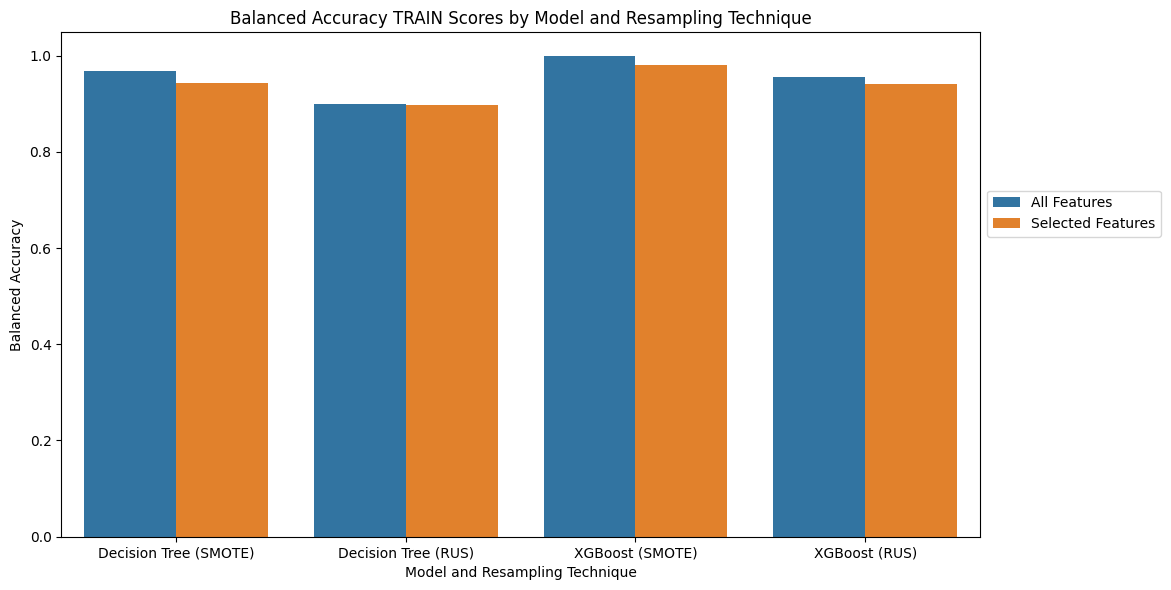

In [ ]:
# Plot bar chart of balanced accuracies

plt.figure(figsize=(10, 6))
sns.barplot(x='Model and Resampling', y='Balanced Accuracy', hue='Feature Selection', data=balanced_accuracy_train)
plt.title('Balanced Accuracy TRAIN Scores by Model and Resampling Technique')
plt.xlabel('Model and Resampling Technique')
plt.ylabel('Balanced Accuracy')
plt.xticks()
plt.tight_layout()
plt.legend(bbox_to_anchor=(1, 0.7), loc='upper left')
plt.show()

## Precision, Recall, F-beta

In [51]:
## Calculate recall of each class for each model
precision_scores = {
    'Decision Tree (SMOTE)': precision_score(y_test, dt_smote.predict(X_test), average=None),
    'Decision Tree (SMOTE with Feature Selection)': precision_score(y_fs_test, dt_smote_fs.predict(X_fs_test), average=None),
    'Decision Tree (RUS)': precision_score(y_test, dt_rus.predict(X_test), average=None),
    'Decision Tree (RUS with Feature Selection)': precision_score(y_fs_test, dt_rus_fs.predict(X_fs_test), average=None),
    'XGBoost (SMOTE)': precision_score(y_test-1, xg_smote.predict(X_test), average=None),
    'XGBoost (SMOTE with Feature Selection)': precision_score(y_fs_test-1, xg_smote_fs.predict(X_fs_test), average=None),
    'XGBoost (RUS)': precision_score(y_test-1, xg_rus.predict(X_test), average=None),
    'XGBoost (RUS with Feature Selection)': precision_score(y_fs_test-1, xg_rus_fs.predict(X_fs_test), average=None)
}


## Initialise empty list to store model information and scores
df = []

## Loop through dictionary, extract model information and balanced accuracy scores
for key, value in precision_scores.items():
    model_info = key.split(' (')
    model_type = model_info[0]
    #feature_selection = 'Selected Features' if 'with Feature Selection' in key else 'All Features'
    feature_selection = '+ FS' if 'with Feature Selection' in key else ''
    resampling_info = model_info[1].split(' ')
    resampling = resampling_info[0] if 'with Feature Selection' in key else resampling_info[0][:-1]
    precision_N = round(value[0],2)
    precision_S = round(value[1],2)
    precision_P = round(value[2],2)
    df.append([f"{model_type}", f"{resampling} {feature_selection}", precision_N, precision_S, precision_P])

## Create DataFrame
precision_df = pd.DataFrame(df, columns=['Model', 'Resampling', 'Precision (N)', 'Precision (S)', 'Precision (P)'])
precision_df

,Model,Resampling,Precision (N),Precision (S),Precision (P)
0,Decision Tree,SMOTE,0.95,0.75,0.91
1,Decision Tree,SMOTE + FS,0.98,0.93,1.00
2,Decision Tree,RUS,0.96,0.65,0.85
3,Decision Tree,RUS + FS,0.99,0.58,0.89
4,XGBoost,SMOTE,0.96,0.87,0.91
5,XGBoost,SMOTE + FS,0.99,0.92,1.00
6,XGBoost,RUS,1.00,0.61,0.80
7,XGBoost,RUS + FS,1.00,0.61,0.76


In [52]:
## Calculate recall of each class for each model
recall_scores = {
    'Decision Tree (SMOTE)': recall_score(y_test, dt_smote.predict(X_test), average=None),
    'Decision Tree (SMOTE with Feature Selection)': recall_score(y_fs_test, dt_smote_fs.predict(X_fs_test), average=None),
    'Decision Tree (RUS)': recall_score(y_test, dt_rus.predict(X_test), average=None),
    'Decision Tree (RUS with Feature Selection)': recall_score(y_fs_test, dt_rus_fs.predict(X_fs_test), average=None),
    'XGBoost (SMOTE)': recall_score(y_test-1, xg_smote.predict(X_test), average=None),
    'XGBoost (SMOTE with Feature Selection)': recall_score(y_fs_test-1, xg_smote_fs.predict(X_fs_test), average=None),
    'XGBoost (RUS)': recall_score(y_test-1, xg_rus.predict(X_test), average=None),
    'XGBoost (RUS with Feature Selection)': recall_score(y_fs_test-1, xg_rus_fs.predict(X_fs_test), average=None)
}


## Initialise empty list to store model information and scores
df = []

## Loop through dictionary, extract model information and balanced accuracy scores
for key, value in recall_scores.items():
    model_info = key.split(' (')
    model_type = model_info[0]
    #feature_selection = 'Selected Features' if 'with Feature Selection' in key else 'All Features'
    feature_selection = '+ FS' if 'with Feature Selection' in key else ''
    resampling_info = model_info[1].split(' ')
    resampling = resampling_info[0] if 'with Feature Selection' in key else resampling_info[0][:-1]
    recall_N = round(value[0],2)
    recall_S = round(value[1],2)
    recall_P = round(value[2],2)
    df.append([f"{model_type}", f"{resampling} {feature_selection}", recall_N, recall_S, recall_P])

## Create DataFrame
recall_df = pd.DataFrame(df, columns=['Model', 'Resampling', 'Recall (N)', 'Recall (S)', 'Recall (P)'])
recall_df

,Model,Resampling,Recall (N),Recall (S),Recall (P)
0,Decision Tree,SMOTE,0.95,0.72,0.91
1,Decision Tree,SMOTE + FS,0.99,0.86,1.00
2,Decision Tree,RUS,0.90,0.83,0.97
3,Decision Tree,RUS + FS,0.87,0.95,0.91
4,XGBoost,SMOTE,0.98,0.78,0.91
5,XGBoost,SMOTE + FS,0.98,0.95,1.00
6,XGBoost,RUS,0.88,0.95,0.94
7,XGBoost,RUS + FS,0.85,1.00,1.00


In [54]:
## Calculate recall of each class for each model
fbeta_scores = {
    'Decision Tree (SMOTE)': fbeta_score(y_test, dt_smote.predict(X_test), beta = 2, average=None),
    'Decision Tree (SMOTE with Feature Selection)': fbeta_score(y_fs_test, dt_smote_fs.predict(X_fs_test), beta = 2, average=None),
    'Decision Tree (RUS)': fbeta_score(y_test, dt_rus.predict(X_test), beta = 2, average=None),
    'Decision Tree (RUS with Feature Selection)': fbeta_score(y_fs_test, dt_rus_fs.predict(X_fs_test), beta = 2, average=None),
    'XGBoost (SMOTE)': fbeta_score(y_test-1, xg_smote.predict(X_test), beta = 2, average=None),
    'XGBoost (SMOTE with Feature Selection)': fbeta_score(y_fs_test-1, xg_smote_fs.predict(X_fs_test), beta = 2, average=None),
    'XGBoost (RUS)': fbeta_score(y_test-1, xg_rus.predict(X_test), beta = 2, average=None),
    'XGBoost (RUS with Feature Selection)': fbeta_score(y_fs_test-1, xg_rus_fs.predict(X_fs_test), beta = 2, average=None)
}


## Initialise empty list to store model information and scores
df = []

## Loop through dictionary, extract model information and balanced accuracy scores
for key, value in fbeta_scores.items():
    model_info = key.split(' (')
    model_type = model_info[0]
    #feature_selection = 'Selected Features' if 'with Feature Selection' in key else 'All Features'
    feature_selection = '+ FS' if 'with Feature Selection' in key else ''
    resampling_info = model_info[1].split(' ')
    resampling = resampling_info[0] if 'with Feature Selection' in key else resampling_info[0][:-1]
    fbeta_N = round(value[0],2)
    fbeta_S = round(value[1],2)
    fbeta_P = round(value[2],2)
    df.append([f"{model_type}", f"{resampling} {feature_selection}", fbeta_N, fbeta_S, fbeta_P])

## Create DataFrame
fbeta_df = pd.DataFrame(df, columns=['Model', 'Resampling', 'F-Beta (N)', 'F-Beta (S)', 'F-Beta (P)'])
fbeta_df

,Model,Resampling,F-Beta (N),F-Beta (S),F-Beta (P)
0,Decision Tree,SMOTE,0.95,0.73,0.91
1,Decision Tree,SMOTE + FS,0.99,0.87,1.00
2,Decision Tree,RUS,0.91,0.78,0.94
3,Decision Tree,RUS + FS,0.89,0.84,0.91
4,XGBoost,SMOTE,0.98,0.79,0.91
5,XGBoost,SMOTE + FS,0.99,0.94,1.00
6,XGBoost,RUS,0.90,0.85,0.91
7,XGBoost,RUS + FS,0.88,0.89,0.94
